In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import linregress
import os

#For plotting binned velocity profile
from scipy.stats import binned_statistic as bstats

In [2]:
# Import and apply style file for plots
plt.style.use("mpl.style")

## System properties

In [3]:
#In LJ units

#System size
L_x = 10 #Size of the system

#Fluid properties
eta = 0.01
rho = 1
nu = eta/rho

#Oscillation properties
u_0 = 0.1
k_x = 2*np.pi/L_x

#Decay timescale
tau = 1/nu/(k_x**2)

#### Functional Expression for Velocity

In [4]:
#This expression returns the magnitude of velocity vectors only
def vel_x_y_t(x,t,k_x,tau):
    u_x = u_0*np.sin(k_x*x)
    u_t = np.exp(-t/tau)
    return np.sum(np.abs(u_x), axis=1)*u_t

## Retrieve netCDF datasets

In [5]:
from netCDF4 import Dataset

In [6]:
filepath = '/home/epalermo/dev/test/taylor_green_1D/data_files'

#Compile all filenames (value) and properties (key) into a dictionary
data_files = {}

for file in os.listdir(filepath):
    
    #Remove the .nc extension
    #Collect the info for the run in an array
    file_info = file.split(".")
    file_info = file_info[0].split("_")
    
    #File name
    file_name = file
    
    #Add the files to datafiles dictionary
    data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name

    

## Kinetic Energy vs Time

Text(0.5, 0, 't')

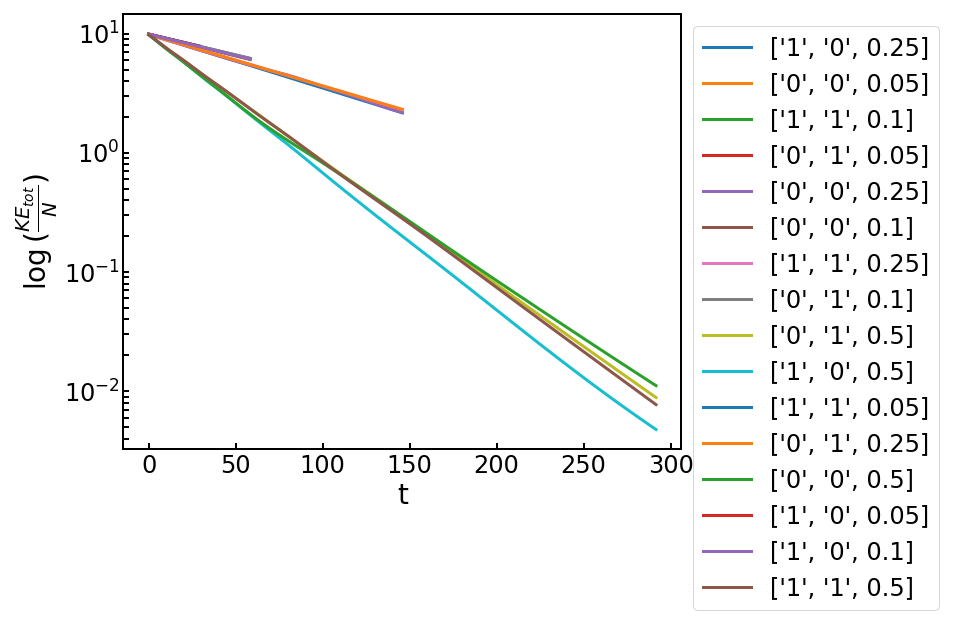

In [7]:
fig = plt.figure()


all_run_info = []

for run in data_files:
    run_info = list(run)[0:2]
    ds = Dataset(data_files[run])
    
    #Scaling variables
    sf = 1/int(list(run)[2]) #Scaling of unit cell
    N = L_x*3.5/sf**2 # Total number of atoms
    n = 1/sf**2 #Number density - number of particles per volume
    mp = rho/n #Mass of particles (density is constant)
    
    run_info.append(sf)
     
    #Kinetic energy from data
    td = ds["time"][:]
    xd = ds['coordinates'][:,:,0] #At timestep nf, for all particles, x position
    vyd = ds["velocities"][:,:,1] #At timestep nf, for all particles, x position
    Exd = 0.5*mp*(np.sum(np.abs(vyd), axis=1))**2
    E_tot = Exd
    
    #Viscosity calculation from slope of semilogy(E_tot vs t)
    slope_d = linregress(td, np.log(E_tot))[0]
    nu_d = -slope_d/(2*(k_x**2)) #Kinematic viscosity from data
    
    #Kinetic energy from analytic solution
    ref_vx = vel_x_y_t(xd,td,k_x,tau)
    ref_Ex = 0.5*mp*(ref_vx)**2
    ref_E_tot = ref_Ex
    
    #Viscosity calculation from analytical solution
    slope_ref = linregress(td, np.log(ref_E_tot))[0]
    nu_ref = -slope_ref/(2*(k_x**2)) #Kinematic viscosity from data

    #Error
    nu_error = np.abs(nu_ref-nu_d)
    run_info.append(nu_error)
    
    all_run_info.append(run_info)
    
    plt.semilogy(td, E_tot, label = run_info[0:3])

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel(r"$\log{(\frac{KE_{tot}}{N})}$")
plt.xlabel("t")

In [8]:
df = pd.DataFrame(all_run_info, columns=["Shifting","RK","sf","Viscosity Error"])
df.sort_values(by=["sf"], inplace=True)

   Shifting RK    sf  Viscosity Error
1         0  0  0.05         0.000446
5         0  0  0.10         0.000659
4         0  0  0.25         0.002945
12        0  0  0.50         0.019096
   Shifting RK    sf  Viscosity Error
3         0  1  0.05         0.000019
7         0  1  0.10         0.000164
11        0  1  0.25         0.002610
8         0  1  0.50         0.020417
   Shifting RK    sf  Viscosity Error
10        1  1  0.05         0.000019
2         1  1  0.10         0.000164
6         1  1  0.25         0.002633
15        1  1  0.50         0.020982
   Shifting RK    sf  Viscosity Error
13        1  0  0.05         0.000316
14        1  0  0.10         0.000407
0         1  0  0.25         0.003194
9         1  0  0.50         0.023433


Text(0.5, 0, '${\\Delta x}$')

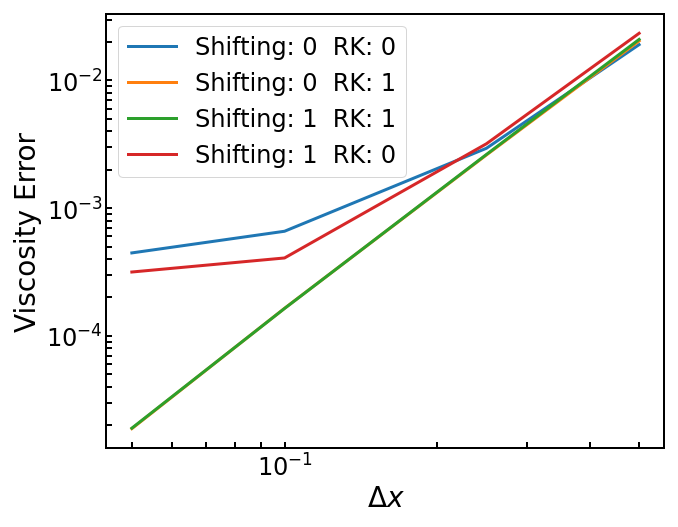

In [9]:
fig = plt.figure()


for i in df["Shifting"].unique():
    df_1 = df[df["Shifting"]==i]
    for j in df_1["RK"].unique():
        df_2 = df_1[df_1["RK"]==j]
        label = "Shifting: " + i + "  " +"RK: " + j
        plt.loglog(df_2["sf"],df_2["Viscosity Error"],label=label)
        print(df_2)
        
plt.legend()
plt.ylabel('Viscosity Error')
plt.xlabel(r"${\Delta x}$")